In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fanalysis
from fanalysis.mca import MCA

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 61kB 5.1MB/s 
Mounted at /content/drive


In [2]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [3]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [4]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str )#, dtype='Int64')


In [5]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1219999, 23)

In [6]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,000000010010000001,02,81,08,91,09,06,21,21,01,71,41,07,04,12,04,20,02,02,01,51,05,1
1,000000020010000006,01,75,07,43,04,06,06,13,02,71,64,07,06,12,09,04,12,04,13,12,01,1
2,000000030010000011,01,76,07,43,04,06,06,16,03,54,81,05,08,07,12,06,06,04,18,36,03,2
3,000000040010000013,03,75,07,43,04,04,06,13,01,71,36,07,03,12,11,11,19,04,06,21,02,1
4,000000050010000015,02,33,03,44,04,06,07,12,01,71,42,07,04,12,05,14,03,03,01,14,01,2


In [7]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        

def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train)))  
    print(classification_report(y_train, model.predict(X_train) ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne Top_mon :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data

    

In [8]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,1219999,1219999
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,ImmoFaz_Scl,31,31
5,ImmoFaz_cl,9,9
6,Anciennete,11,11
7,Logement_prix_m2,21,21
8,Mediane_RFR,21,21
9,Sexe,5,5


In [9]:
data["Top_mon"].value_counts(dropna=False)

NaN    1092884
2       103659
1        23456
Name: Top_mon, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219999 entries, 0 to 1219998
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1219999 non-null  object
 1   TypeHabi            1219999 non-null  object
 2   GeoFaz_Scl          1219999 non-null  object
 3   GeoFaz_cl           1219999 non-null  object
 4   ImmoFaz_Scl         1219999 non-null  object
 5   ImmoFaz_cl          1219999 non-null  object
 6   Anciennete          1219999 non-null  object
 7   Logement_prix_m2    1219999 non-null  object
 8   Mediane_RFR         1219999 non-null  object
 9   Sexe                1219999 non-null  object
 10  Prenom_Phase_scl_H  1219999 non-null  object
 11  Prenom_Phase_scl_F  1219999 non-null  object
 12  Prenom_Phase_cl_H   1219999 non-null  object
 13  Prenom_Phase_cl_F   1219999 non-null  object
 14  Age_H               1219999 non-null  object
 15  Age_F               1219999 non-

In [11]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine les variables corr
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)


In [12]:
num_var_max = data.shape[1] - 1
num_var_max

15

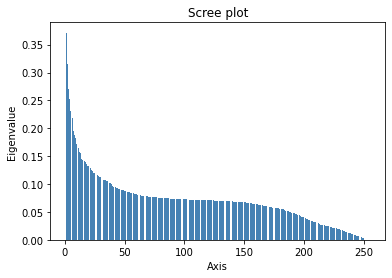

None


In [13]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
acm.fit(data.iloc[:127115,1:num_var_max].values)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [14]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [15]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=15)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
acm.fit(data.iloc[:127115,1:num_var_max].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [16]:
# dimension
coord.shape

(1219999, 15)

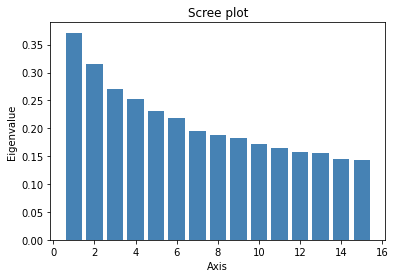

None


In [17]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [18]:
#coordonnées des colonnes
print(acm.col_topandas())

                     col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_01                0.328441       -0.201417        0.223749   
TypeHabi_02               -0.143567        0.074169       -0.091876   
TypeHabi_03                0.136197       -0.000884        0.047311   
TypeHabi_04                0.058198       -0.737083        1.988520   
GeoFaz_Scl_11             -0.122568       -0.004153        0.081375   
...                             ...             ...             ...   
Potentiel_prenom_17       -1.288291        0.051224       -0.866692   
Potentiel_prenom_18       -1.148183        0.040895       -0.256930   
Potentiel_prenom_19       -1.246651        0.016201        0.821046   
Potentiel_prenom_20       -1.141801        0.022557        1.248943   
Potentiel_prenom_21        0.308138       -5.969901       -0.508811   

                     col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_01               -0.255346        0.196996       -0.219208   
TypeH

In [19]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


15
[[ 3.59309123e-02 -2.39199727e-02  2.86685910e-02 ...  6.67892334e-03
  -1.55116590e-02  4.77439712e-02]
 [-1.57060041e-02  8.80819897e-03 -1.17719599e-02 ... -3.80070006e-03
   2.50967539e-03 -1.41761250e-02]
 [ 1.48997091e-02 -1.04952469e-04  6.06181284e-03 ...  7.14385023e-03
   1.80968427e-02 -1.69337075e-02]
 ...
 [-1.36381364e-01  1.92394723e-03  1.05199151e-01 ...  1.23348091e-02
   2.18303711e-01  8.61076405e-02]
 [-1.24910962e-01  2.67886812e-03  1.60024836e-01 ...  2.60465944e-01
   6.16243623e-02  1.12254295e-02]
 [ 3.37097482e-02 -7.08975837e-01 -6.51930632e-02 ...  2.06036490e-02
   1.23201915e-02 -8.65511137e-03]]
                           0         1         2         3         4   \
TypeHabi_01          0.035931 -0.023920  0.028669 -0.033839  0.027299   
TypeHabi_02         -0.015706  0.008808 -0.011772  0.012781 -0.010957   
TypeHabi_03          0.014900 -0.000105  0.006062 -0.003174  0.004302   
TypeHabi_04          0.006367 -0.087535  0.254786  0.073725  0.249701

In [20]:
# affichafe des 10 premières lignes
print(coord[:2,:])


[[ 0.90897938 -0.20511943  1.57517015 -0.30513616  1.53599785 -0.1200081
  -4.73799717 -0.2425337   0.03879453 -0.15027436 -0.35578542 -0.44997252
   0.01852557  0.69644359  0.32477728]
 [ 0.60676659  0.06940016  0.10698411 -0.15732134 -0.53774169 -0.50235749
  -0.04348663 -0.00777334 -0.13122926  0.35807359  0.21733094 -0.09959889
  -0.11285631 -0.35949989  0.14576174]]


In [21]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219999 entries, 0 to 1219998
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1219999 non-null  object
 1   TypeHabi            1219999 non-null  object
 2   GeoFaz_Scl          1219999 non-null  object
 3   Anciennete          1219999 non-null  object
 4   Logement_prix_m2    1219999 non-null  object
 5   Mediane_RFR         1219999 non-null  object
 6   Sexe                1219999 non-null  object
 7   Prenom_Phase_scl_H  1219999 non-null  object
 8   Prenom_Phase_scl_F  1219999 non-null  object
 9   Age_H               1219999 non-null  object
 10  Age_F               1219999 non-null  object
 11  Affinite_1          1219999 non-null  object
 12  Affinite_2          1219999 non-null  object
 13  Prenom_effectif     1219999 non-null  object
 14  Potentiel_prenom    1219999 non-null  object
 15  Top_mon             127115 non-n

In [22]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable Top_mon
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1] ): #avant 10
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable Top_mon

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1]): # avant 10
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["Top_mon"] = dfff["Top_mon"].replace(1.0, '1')
    dfff["Top_mon"] = dfff["Top_mon"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 127115 entries, 0 to 127114
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   IDENT    127115 non-null  object 
 1   0        127115 non-null  float64
 2   1        127115 non-null  float64
 3   2        127115 non-null  float64
 4   3        127115 non-null  float64
 5   4        127115 non-null  float64
 6   5        127115 non-null  float64
 7   6        127115 non-null  float64
 8   7        127115 non-null  float64
 9   8        127115 non-null  float64
 10  9        127115 non-null  float64
 11  10       127115 non-null  float64
 12  11       127115 non-null  float64
 13  12       127115 non-null  float64
 14  13       127115 non-null  float64
 15  14       127115 non-null  float64
 16  Top_mon  127115 non-null  int64  
dtypes: float64(15), int64(1), object(1)
memory usage: 17.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219999 entries, 0 to 1219998
Data

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
#data_coord_nan.shape
#train_X_s.shape

In [25]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting :
# Résultat du traitement sur le train set (under-sampling et over-sampling)
#abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
#abc_np = abc_test.to_numpy(dtype="Int64")

#X_resampled = abc_np[:,:-1]
#y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [26]:

# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks()
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE()
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))

'''
# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
'''

Sans aucun traitement sur le train set :  (array([1, 2]), array([18777, 82915]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Après under-sampling :  (array([1, 2]), array([18777, 78378]))
Après over-smapling :  (array([1, 2]), array([78378, 78378]))


'\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [27]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.001,0.01]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

In [28]:
model_17 = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(model_17, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)

test set : 
[[ 2648  2031]
 [ 8004 12740]]
              precision    recall  f1-score   support

           1       0.25      0.57      0.35      4679
           2       0.86      0.61      0.72     20744

    accuracy                           0.61     25423
   macro avg       0.56      0.59      0.53     25423
weighted avg       0.75      0.61      0.65     25423

train set : 
[[43736 34642]
 [29614 48764]]
              precision    recall  f1-score   support

           1       0.60      0.56      0.58     78378
           2       0.58      0.62      0.60     78378

    accuracy                           0.59    156756
   macro avg       0.59      0.59      0.59    156756
weighted avg       0.59      0.59      0.59    156756

GRAPHIQUE NON DEMANDE


In [29]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["Top_mon"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [30]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_01,-0.142084
TypeHabi_02,0.058531
TypeHabi_03,-0.036829
TypeHabi_04,-0.333502
GeoFaz_Scl_11,-0.022825
...,...
Potentiel_prenom_17,-0.039109
Potentiel_prenom_18,-0.067851
Potentiel_prenom_19,-0.072167
Potentiel_prenom_20,-0.081184


In [31]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model =adl, data_orig = data_coord_nan, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")

                     IDENT     PROBA
102867  001028680010415933  0.065663
14333   000143340010258123  0.067659
107833  001078340010505522  0.069325
29213   000292140010339331  0.069603
29214   000292150010339331  0.069603
...                    ...       ...
112466  001124670010522219  0.630769
99937   000999380010413455  0.630769
6983    000069840010197221  0.630769
80877   000808780010395959  0.630769
108290  001082910010515442  0.630769

[127115 rows x 2 columns]
0.630769    50
0.580891    33
0.386826    33
0.428201    26
0.481677    23
            ..
0.229852     1
0.126826     1
0.122635     1
0.128450     1
0.110780     1
Name: PROBA, Length: 96552, dtype: int64
                   PROBA
102867  (0.0647, 0.0974]
14333   (0.0647, 0.0974]
107833  (0.0647, 0.0974]
29213   (0.0647, 0.0974]
29214   (0.0647, 0.0974]
...                  ...
112466    (0.348, 0.631]
99937     (0.348, 0.631]
6983      (0.348, 0.631]
80877     (0.348, 0.631]
108290    (0.348, 0.631]

[127115 rows x 1 colum

In [32]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = adl, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ADL.xlsx")

                      IDENT     PROBA
1115845  009887310370005194  0.062451
457551   003304370140002616  0.062832
333411   002062970120003566  0.062956
712578   005854640270017537  0.064069
1040345  009132310360089694  0.064708
...                     ...       ...
665837   005387230250010802  0.630769
1155940  010288260370045289  0.630769
1145278  010181640370034627  0.630769
1135162  010080480370024511  0.630769
657368   005302540250002333  0.630769

[1092884 rows x 2 columns]
0.428201    303
0.606720    229
0.531358    223
0.580891    222
0.539953    214
           ... 
0.201271      1
0.185264      1
0.101039      1
0.237376      1
0.150889      1
Name: PROBA, Length: 838236, dtype: int64
                   PROBA
1115845  (0.0615, 0.095]
457551   (0.0615, 0.095]
333411   (0.0615, 0.095]
712578   (0.0615, 0.095]
1040345  (0.0615, 0.095]
...                  ...
665837    (0.362, 0.631]
1155940   (0.362, 0.631]
1145278   (0.362, 0.631]
1135162   (0.362, 0.631]
657368    (0.362, 0.631

In [33]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)


test set : 
[[ 1561  3118]
 [ 4000 16744]]
              precision    recall  f1-score   support

           1       0.28      0.33      0.30      4679
           2       0.84      0.81      0.82     20744

    accuracy                           0.72     25423
   macro avg       0.56      0.57      0.56     25423
weighted avg       0.74      0.72      0.73     25423

train set : 
[[25608 52770]
 [14683 63695]]
              precision    recall  f1-score   support

           1       0.64      0.33      0.43     78378
           2       0.55      0.81      0.65     78378

    accuracy                           0.57    156756
   macro avg       0.59      0.57      0.54    156756
weighted avg       0.59      0.57      0.54    156756

GRAPHIQUE NON DEMANDE


In [35]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model =model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")

                     IDENT     PROBA
13793   000137940010257726  0.011439
78876   000788770010394181  0.012201
33209   000332100010343438  0.012264
10870   000108710010255388  0.012347
31930   000319310010341998  0.012459
...                    ...       ...
112730  001127310010522857  1.000000
56597   000565980010368943  1.000000
91186   000911870010404532  1.000000
121821  001218220010533437  1.000000
54564   000545650010367356  1.000000

[127115 rows x 2 columns]
1.000000    107
1.000000     50
1.000000     33
0.959994     33
0.994878     26
           ... 
0.030638      1
0.775405      1
0.211847      1
0.779543      1
0.105906      1
Name: PROBA, Length: 96455, dtype: int64
                   PROBA
13793   (0.0104, 0.0632]
78876   (0.0104, 0.0632]
33209   (0.0104, 0.0632]
10870   (0.0104, 0.0632]
31930   (0.0104, 0.0632]
...                  ...
112730      (0.979, 1.0]
56597       (0.979, 1.0]
91186       (0.979, 1.0]
121821      (0.979, 1.0]
54564       (0.979, 1.0]

[127115 row

In [ ]:
#################################################################################
#################################################################################

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


In [ ]:
###########################################################################################################

In [37]:
from sklearn.pipeline import Pipeline 

In [41]:
disqual =  Pipeline([("acm", MCA(var_labels = data.columns[1:num_var_max], )),("adl", LinearDiscriminantAnalysis())])

In [ ]:
disqual.fit(data.iloc[:127115, 1:-1].values, data.iloc[:127115, num_var_max] )

In [ ]:
#accès à l'ACM, nombre de composants
print(disqual.named_steps["acm"].n_components_)


In [ ]:
#afficher les valeurs propres
disqual.named_steps["acm"].plot_eigenvalues()


In [ ]:
#coefs. de la fonction score
print(disqual.named_steps["adl"].coef_)


In [ ]:
#prediction
pVote = disqual.predict(vote_test.iloc[:,:-1].values)
print(numpy.unique(pVote,return_counts=True))


In [ ]:
#nombres de facteurs à tester
parametres = [{"acm__n_components":[1,2,5,10,15,20,25,30,32]}]

In [1]:
data.iloc[:127115, 1:-1]

NameError: ignored